In [1]:
#The only thing to include in the paper/presentation from this code is the bar graph

import numpy as np
from matplotlib import pyplot as plt
from sklearn import preprocessing
#import wfdb
import copy as cp
import scipy.signal as signal
import pickle
from sklearn import preprocessing
from tqdm import tqdm
import os
import re
import pandas as pd
import csv

from sklearn.linear_model import LogisticRegression
from sklearn import neighbors
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis 
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from time import time
import timeit

import random
random.seed(1000)

In [2]:
%matplotlib inline
plt.rcParams['figure.dpi'] = 70 #display 70 dpi in Jupyter Notebook, may consider100 dpi 
plt.rcParams['savefig.dpi'] = 300 #define 300 dpi for saving figures

import seaborn as sns
## here are some settings 
sns.set_style('whitegrid')
sns.set(rc={"figure.dpi":70, 'savefig.dpi':300}) #defining dpi setting
sns.set_context('notebook')
sns.set_style("ticks")
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

#sns.set(rc={'figure.figsize':(11.7,8.27)})

# Side to side comparison plots

In [3]:
statallfeatures_dic = {
    'Run Time': [],
    'Accuracy': [],   ## To store the MEAN accuracy for 5-fold CV for each model
    'Standard Error': [],
    'Sensitivity': [],
    'Specificity': [],
    'Precision': [],
    'F1_Score': []   
}

In [4]:
## To store the accuracy for 5-fold CV for each model
indaccs_dic = {}

2017 train -> 2021 test

In [5]:
df1 = pd.read_csv("JORN17_dataset_v2.csv", na_values = '?').dropna()
df1['year'] = 2017
df2 = pd.read_csv("JORN21_dataset_v1.csv", na_values = '?').dropna()
df2['year'] = 2021
frames = [df1, df2]
df = pd.concat(frames)
df = df.reindex(columns=['OID_', 'Id', 'gridcode', 'Shape_Length', 'Shape_Area', 'CH_mean', 'ARVI_mean', 'ARVI_med', 'ARVI_max', 'EVI_mean', 'EVI_med', 'EVI_max', 'NDVI_mean', 'NDVI_med', 'NDVI_max', 'SAVI_mean', 'SAVI_med', 'SAVI_max', 'year', 'Veg_class'])
df


,OID_,Id,gridcode,Shape_Length,Shape_Area,CH_mean,ARVI_mean,ARVI_med,ARVI_max,EVI_mean,EVI_med,EVI_max,NDVI_mean,NDVI_med,NDVI_max,SAVI_mean,SAVI_med,SAVI_max,year,Veg_class
0,2,2,2,16.0,4.79,0.010000,0.223962,0.226896,0.239161,0.273236,0.274394,0.307885,0.402131,0.406066,0.427636,0.278782,0.280285,0.316995,2017,woody
1,3,3,3,8.6,2.24,0.010000,0.287822,0.287822,0.316384,0.302193,0.302193,0.305906,0.448325,0.448325,0.469259,0.301407,0.301407,0.304224,2017,woody
2,4,4,4,27.8,11.12,0.012500,0.289236,0.313074,0.459671,0.300200,0.318621,0.374641,0.447470,0.466219,0.570786,0.298798,0.314429,0.358302,2017,woody
3,5,5,5,24.2,10.62,0.060000,0.330255,0.375986,0.498250,0.313174,0.335601,0.386369,0.477596,0.517136,0.598966,0.309534,0.325886,0.368766,2017,woody
4,6,6,6,17.4,6.10,0.012000,0.275800,0.341526,0.416294,0.264112,0.280268,0.314841,0.431575,0.487791,0.518614,0.266352,0.273629,0.312146,2017,woody
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2226,2278,2278,2278,25.2,6.63,0.015000,0.128259,0.134121,0.167685,0.237659,0.245145,0.256763,0.334798,0.337580,0.365527,0.252164,0.257355,0.268680,2021,non-woody
2227,2279,2279,2279,15.2,5.33,0.134000,0.485618,0.489819,0.519026,0.416102,0.438885,0.441772,0.583201,0.585438,0.603520,0.386171,0.403764,0.410255,2021,woody
2228,2280,2280,2280,17.0,4.98,0.114000,0.313633,0.318283,0.474006,0.350407,0.341923,0.436805,0.483337,0.490012,0.591361,0.350956,0.346441,0.412744,2021,non-woody
2229,2281,2281,2281,19.8,6.49,0.011667,0.119920,0.108993,0.198284,0.230958,0.227932,0.271254,0.323523,0.317326,0.384514,0.243325,0.242532,0.278123,2021,non-woody


In [6]:
#Logistic Regression

kf = KFold(n_splits=5, random_state=3, shuffle=True)
model = LogisticRegression(solver='liblinear')

start_time = timeit.default_timer()

acc_score = []
Truth = []
Output = []

testindex8 = []
testindex9 = []

for train_index, test_index in kf.split(df): 
    
    X_train = df.iloc[train_index, 5:19]
    X_test = df.iloc[test_index, 5:19]
    Y_train = df.iloc[train_index, -1]
    Y_test = df.iloc[test_index, -1]

    model.fit(X_train, Y_train)
    pred_values = model.predict(X_test)

    acc = accuracy_score(Y_test, pred_values)
    acc_score.append(acc)

    Truth.extend(Y_test.values.reshape(Y_test.shape[0])) 
    Output.extend(pred_values)
    
    testindex8.append(test_index)
    testindex9.append(pred_values)

elapsed = timeit.default_timer() - start_time



print("---Run time is %s seconds ---" % elapsed)
print()
print('Accuracy of each fold: \n {}'.format(acc_score))
print("Avg accuracy: {}".format(np.mean(acc_score)))
print('Std of accuracy : \n{}'.format(np.std(acc_score)))
print()
print(confusion_matrix(Truth, Output))
print()
print(classification_report(Truth, Output))

cm = confusion_matrix(Truth, Output)

sensitivity = cm[0][0]/(cm[0][0]+cm[0][1])
specificity = cm[1][1]/(cm[1][0]+cm[1][1])
precision = (cm[0][0])/(cm[0][0]+cm[1][0])
f1_score = (2*precision*sensitivity)/(precision+sensitivity)

print(sensitivity)
print(specificity)
print(precision)
print(f1_score)

statallfeatures_dic['Run Time'].append(elapsed)
statallfeatures_dic['Accuracy'].append(np.mean(acc_score))
statallfeatures_dic['Standard Error'].append(np.std(acc_score))
statallfeatures_dic['Sensitivity'].append(sensitivity)
statallfeatures_dic['Specificity'].append(specificity)
statallfeatures_dic['Precision'].append(precision)
statallfeatures_dic['F1_Score'].append(f1_score)

indaccs_dic['LogReg']=acc_score

---Run time is 0.07215430000000023 seconds ---

Accuracy of each fold: 
 [0.7390396659707724, 0.7463465553235908, 0.7630480167014614, 0.7546972860125261, 0.7599164926931107]
Avg accuracy: 0.7526096033402924
Std of accuracy : 
0.008832649603885677

[[ 944  731]
 [ 454 2661]]

              precision    recall  f1-score   support

   non-woody       0.68      0.56      0.61      1675
       woody       0.78      0.85      0.82      3115

    accuracy                           0.75      4790
   macro avg       0.73      0.71      0.72      4790
weighted avg       0.75      0.75      0.75      4790

0.5635820895522388
0.8542536115569823
0.6752503576537912
0.6143833387569151


In [7]:
woodyarea1 = 0
nonwoodyarea1 = 0
totalarea1 = 0

start_time = timeit.default_timer()

for i in testindex8:
    for j in i:
        totalarea1 += df.iat[j,4]
        if df.iat[j,-1] == "woody":
            woodyarea1 += df.iat[j,4]
        if df.iat[j,-1] == "non-woody":
            nonwoodyarea1 += df.iat[j,4]

elapsed = timeit.default_timer() - start_time
print("---Run time is %s seconds ---" % elapsed)
needed = woodyarea1/totalarea1 * 100
print(needed)

---Run time is 0.31524189999999974 seconds ---
19.396377433556005


In [8]:
awoodyarea4 = 0
anonwoodyarea4 = 0
atotalarea4 = 0

start_time = timeit.default_timer()

for i in testindex8:
    for j in i:
        for k in range(0,1):
            for l in testindex9[k]:
                if l == "woody":
                    awoodyarea4 += df.iat[j,4]
                    atotalarea4 += df.iat[j,4]
                if l == "non-woody":
                    anonwoodyarea4 += df.iat[j,4]
                    atotalarea4 += df.iat[j,4]
elapsed = timeit.default_timer() - start_time
print("---Run time is %s seconds ---" % elapsed)
aFWC4 = awoodyarea4/atotalarea4 * 100
                    
print(aFWC4)

---Run time is 146.743143 seconds ---
71.50313152389707


In [9]:
bwoodyarea4 = 0
bnonwoodyarea4 = 0
btotalarea4 = 0

start_time = timeit.default_timer()

for i in testindex8:
    for j in i:
        for k in range(1,2):
            for l in testindex9[k]:
                if l == "woody":
                    bwoodyarea4 += df.iat[j,4]
                    btotalarea4 += df.iat[j,4]
                if l == "non-woody":
                    bnonwoodyarea4 += df.iat[j,4]
                    btotalarea4 += df.iat[j,4]
elapsed = timeit.default_timer() - start_time
print("---Run time is %s seconds ---" % elapsed)
bFWC4 = bwoodyarea4/btotalarea4 * 100
                    
print(bFWC4)

---Run time is 146.4229793 seconds ---
70.04175365334167


In [10]:
cwoodyarea4 = 0
cnonwoodyarea4 = 0
ctotalarea4 = 0

start_time = timeit.default_timer()

for i in testindex8:
    for j in i:
        for k in range(2,3):
            for l in testindex9[k]:
                if l == "woody":
                    cwoodyarea4 += df.iat[j,4]
                    ctotalarea4 += df.iat[j,4]
                if l == "non-woody":
                    cnonwoodyarea4 += df.iat[j,4]
                    ctotalarea4 += df.iat[j,4]
elapsed = timeit.default_timer() - start_time
print("---Run time is %s seconds ---" % elapsed)
cFWC4 = cwoodyarea4/ctotalarea4 * 100
                    
print(cFWC4)

---Run time is 145.9667387 seconds ---
69.51983298527666


In [11]:
dwoodyarea4 = 0
dnonwoodyarea4 = 0
dtotalarea4 = 0

start_time = timeit.default_timer()

for i in testindex8:
    for j in i:
        for k in range(3,4):
            for l in testindex9[k]:
                if l == "woody":
                    dwoodyarea4 += df.iat[j,4]
                    dtotalarea4 += df.iat[j,4]
                if l == "non-woody":
                    dnonwoodyarea4 += df.iat[j,4]
                    dtotalarea4 += df.iat[j,4]
elapsed = timeit.default_timer() - start_time
print("---Run time is %s seconds ---" % elapsed)
dFWC4 = dwoodyarea4/dtotalarea4 * 100
                    
print(dFWC4)

---Run time is 145.64740320000004 seconds ---
73.90396659696702


In [12]:
ewoodyarea4 = 0
enonwoodyarea4 = 0
etotalarea4 = 0

start_time = timeit.default_timer()

for i in testindex8:
    for j in i:
        for k in range(4,5):
            for l in testindex9[k]:
                if l == "woody":
                    ewoodyarea4 += df.iat[j,4]
                    etotalarea4 += df.iat[j,4]
                if l == "non-woody":
                    enonwoodyarea4 += df.iat[j,4]
                    etotalarea4 += df.iat[j,4]
elapsed = timeit.default_timer() - start_time
print("---Run time is %s seconds ---" % elapsed)
eFWC4 = ewoodyarea4/etotalarea4 * 100
                    
print(eFWC4)

---Run time is 143.5564144000001 seconds ---
69.1022964508313


In [13]:
tFWC4 = (aFWC4 +bFWC4 +cFWC4 +dFWC4 +eFWC4) / 5
print(tFWC4)

70.81419624206276


In [14]:
#LDA
kf = KFold(n_splits=5, random_state=3, shuffle=True)
model=LinearDiscriminantAnalysis()

acc_score = []
Truth = []
Output = []

testindex1 = []
testindex2 = []
  
for train_index, test_index in kf.split(df): 
    X_train = df.iloc[train_index, 5:19]
    X_test = df.iloc[test_index, 5:19]
    Y_train = df.iloc[train_index, -1]
    Y_test = df.iloc[test_index, -1]


    model.fit(X_train, Y_train)
    pred_values = model.predict(X_test)

    acc = accuracy_score(Y_test, pred_values)
    acc_score.append(acc)

    Truth.extend(Y_test.values.reshape(Y_test.shape[0])) 
    Output.extend(pred_values)
    
    testindex1.append(test_index)
    testindex2.append(pred_values)

elapsed = timeit.default_timer() - start_time



print("---Run time is %s seconds ---" % elapsed)
print()
print('Accuracy of each fold: \n {}'.format(acc_score))
print("Avg accuracy: {}".format(np.mean(acc_score)))
print('Std of accuracy : \n{}'.format(np.std(acc_score)))
print()
print(confusion_matrix(Truth, Output))
print()
print(classification_report(Truth, Output))

cm = confusion_matrix(Truth, Output)

sensitivity = cm[0][0]/(cm[0][0]+cm[0][1])
specificity = cm[1][1]/(cm[1][0]+cm[1][1])
precision = (cm[0][0])/(cm[0][0]+cm[1][0])
f1_score = (2*precision*sensitivity)/(precision+sensitivity)

print(sensitivity)
print(specificity)
print(precision)
print(f1_score)

statallfeatures_dic['Run Time'].append(elapsed)
statallfeatures_dic['Accuracy'].append(np.mean(acc_score))
statallfeatures_dic['Standard Error'].append(np.std(acc_score))
statallfeatures_dic['Sensitivity'].append(sensitivity)
statallfeatures_dic['Specificity'].append(specificity)
statallfeatures_dic['Precision'].append(precision)
statallfeatures_dic['F1_Score'].append(f1_score)

indaccs_dic['LDA']=acc_score

---Run time is 143.69945030000008 seconds ---

Accuracy of each fold: 
 [0.7849686847599165, 0.7745302713987474, 0.7881002087682673, 0.7839248434237995, 0.7860125260960334]
Avg accuracy: 0.7835073068893528
Std of accuracy : 
0.004696126045595824

[[1127  548]
 [ 489 2626]]

              precision    recall  f1-score   support

   non-woody       0.70      0.67      0.68      1675
       woody       0.83      0.84      0.84      3115

    accuracy                           0.78      4790
   macro avg       0.76      0.76      0.76      4790
weighted avg       0.78      0.78      0.78      4790

0.6728358208955224
0.8430176565008025
0.6974009900990099
0.6848982072318445


In [15]:
woodyarea1 = 0
nonwoodyarea1 = 0
totalarea1 = 0

start_time = timeit.default_timer()

for i in testindex1:
    for j in i:
        totalarea1 += df.iat[j,4]
        if df.iat[j,-1] == "woody":
            woodyarea1 += df.iat[j,4]
        if df.iat[j,-1] == "non-woody":
            nonwoodyarea1 += df.iat[j,4]

elapsed = timeit.default_timer() - start_time
print("---Run time is %s seconds ---" % elapsed)
print(woodyarea1/totalarea1 * 100)

needed2 = woodyarea1/totalarea1 * 100
print(needed2)

---Run time is 0.31936180000002423 seconds ---
19.396377433556005
19.396377433556005


In [16]:
awoodyarea1 = 0
anonwoodyarea1 = 0
atotalarea1 = 0
start_time = timeit.default_timer()

for i in testindex1:
    for j in i:
        for k in range(0,1):
            for l in testindex2[k]:
                if l == "woody":
                    awoodyarea1 += df.iat[j,4]
                    atotalarea1 += df.iat[j,4]
                if l == "non-woody":
                    anonwoodyarea1 += df.iat[j,4]
                    atotalarea1 += df.iat[j,4]

                    
elapsed = timeit.default_timer() - start_time
print("---Run time is %s seconds ---" % elapsed)
aFWC = awoodyarea1/atotalarea1 * 100
                    
print(aFWC)

---Run time is 149.2392693999999 seconds ---
64.82254697274516


In [17]:
bwoodyarea1 = 0
bnonwoodyarea1 = 0
btotalarea1 = 0
start_time = timeit.default_timer()

for i in testindex1:
    for j in i:
        for k in range(1,2):
            for l in testindex2[k]:
                if l == "woody":
                    bwoodyarea1 += df.iat[j,4]
                    btotalarea1 += df.iat[j,4]
                if l == "non-woody":
                    bnonwoodyarea1 += df.iat[j,4]
                    btotalarea1 += df.iat[j,4]

                    
elapsed = timeit.default_timer() - start_time
print("---Run time is %s seconds ---" % elapsed)
bFWC = bwoodyarea1/btotalarea1 * 100
                    
print(bFWC)

---Run time is 148.90097909999997 seconds ---
64.92693110635457


In [18]:
cwoodyarea1 = 0
cnonwoodyarea1 = 0
ctotalarea1 = 0
start_time = timeit.default_timer()

for i in testindex1:
    for j in i:
        for k in range(2,3):
            for l in testindex2[k]:
                if l == "woody":
                    cwoodyarea1 += df.iat[j,4]
                    ctotalarea1 += df.iat[j,4]
                if l == "non-woody":
                    cnonwoodyarea1 += df.iat[j,4]
                    ctotalarea1 += df.iat[j,4]

                    
elapsed = timeit.default_timer() - start_time
print("---Run time is %s seconds ---" % elapsed)
cFWC = cwoodyarea1/ctotalarea1 * 100
                    
print(cFWC)

---Run time is 149.83554390000018 seconds ---
65.76200417526042


In [19]:
dwoodyarea1 = 0
dnonwoodyarea1 = 0
dtotalarea1 = 0
start_time = timeit.default_timer()

for i in testindex1:
    for j in i:
        for k in range(3,4):
            for l in testindex2[k]:
                if l == "woody":
                    dwoodyarea1 += df.iat[j,4]
                    dtotalarea1 += df.iat[j,4]
                if l == "non-woody":
                    dnonwoodyarea1 += df.iat[j,4]
                    dtotalarea1 += df.iat[j,4]

                    
elapsed = timeit.default_timer() - start_time
print("---Run time is %s seconds ---" % elapsed)
dFWC = dwoodyarea1/dtotalarea1 * 100
                    
print(dFWC)

---Run time is 148.87274839999986 seconds ---
70.35490605417519


In [20]:
ewoodyarea1 = 0
enonwoodyarea1 = 0
etotalarea1 = 0
start_time = timeit.default_timer()

for i in testindex1:
    for j in i:
        for k in range(4,5):
            for l in testindex2[k]:
                if l == "woody":
                    ewoodyarea1 += df.iat[j,4]
                    etotalarea1 += df.iat[j,4]
                if l == "non-woody":
                    enonwoodyarea1 += df.iat[j,4]
                    etotalarea1 += df.iat[j,4]

                    
elapsed = timeit.default_timer() - start_time
print("---Run time is %s seconds ---" % elapsed)
eFWC = ewoodyarea1/etotalarea1 * 100
                    
print(eFWC)

---Run time is 149.92090620000022 seconds ---
65.44885177442617


In [21]:
tFWC = (aFWC + bFWC + cFWC + dFWC + eFWC) / 5
print(tFWC)

66.26304801659231


In [22]:
#QDA
kf = KFold(n_splits=5, random_state=3, shuffle=True)
model=QuadraticDiscriminantAnalysis()

acc_score = []
Truth = []
Output = []

testindex3 = []
testindex4 = []


for train_index, test_index in kf.split(df): 
    X_train = df.iloc[train_index, 5:19]
    X_test = df.iloc[test_index, 5:19]
    Y_train = df.iloc[train_index, -1]
    Y_test = df.iloc[test_index, -1]


    model.fit(X_train, Y_train)
    pred_values = model.predict(X_test)


    acc = accuracy_score(Y_test, pred_values)
    acc_score.append(acc)

    Truth.extend(Y_test.values.reshape(Y_test.shape[0])) 
    Output.extend(pred_values)
    
    testindex3.append(test_index)
    testindex4.append(pred_values)

elapsed = timeit.default_timer() - start_time


print("---Run time is %s seconds ---" % elapsed)
print()
print('Accuracy of each fold: \n {}'.format(acc_score))
print("Avg accuracy: {}".format(np.mean(acc_score)))
print('Std of accuracy : \n{}'.format(np.std(acc_score)))
print()
print(confusion_matrix(Truth, Output))
print()
print(classification_report(Truth, Output))

cm = confusion_matrix(Truth, Output)

sensitivity = cm[0][0]/(cm[0][0]+cm[0][1])
specificity = cm[1][1]/(cm[1][0]+cm[1][1])
precision = (cm[0][0])/(cm[0][0]+cm[1][0])
f1_score = (2*precision*sensitivity)/(precision+sensitivity)

print(sensitivity)
print(specificity)
print(precision)
print(f1_score)

statallfeatures_dic['Run Time'].append(elapsed)
statallfeatures_dic['Accuracy'].append(np.mean(acc_score))
statallfeatures_dic['Standard Error'].append(np.std(acc_score))
statallfeatures_dic['Sensitivity'].append(sensitivity)
statallfeatures_dic['Specificity'].append(specificity)
statallfeatures_dic['Precision'].append(precision)
statallfeatures_dic['F1_Score'].append(f1_score)

indaccs_dic['QDA']=acc_score

---Run time is 149.99468960000013 seconds ---

Accuracy of each fold: 
 [0.7379958246346555, 0.7192066805845512, 0.7359081419624217, 0.7546972860125261, 0.7317327766179541]
Avg accuracy: 0.7359081419624216
Std of accuracy : 
0.011434708924951253

[[1468  207]
 [1058 2057]]

              precision    recall  f1-score   support

   non-woody       0.58      0.88      0.70      1675
       woody       0.91      0.66      0.76      3115

    accuracy                           0.74      4790
   macro avg       0.74      0.77      0.73      4790
weighted avg       0.79      0.74      0.74      4790

0.8764179104477612
0.6603531300160513
0.5811559778305622
0.6988812187574388


In [23]:
woodyarea1 = 0
nonwoodyarea1 = 0
totalarea1 = 0

start_time = timeit.default_timer()

for i in testindex3:
    for j in i:
        totalarea1 += df.iat[j,4]
        if df.iat[j,-1] == "woody":
            woodyarea1 += df.iat[j,4]
        if df.iat[j,-1] == "non-woody":
            nonwoodyarea1 += df.iat[j,4]

elapsed = timeit.default_timer() - start_time
print("---Run time is %s seconds ---" % elapsed)
needed3 = woodyarea1/totalarea1 * 100
print(needed3)

---Run time is 0.3186539000000721 seconds ---
19.396377433556005


In [24]:
awoodyarea2 = 0
anonwoodyarea2 = 0
atotalarea2 = 0
start_time = timeit.default_timer()

for i in testindex3:
    for j in i:
        for k in range(0,1):
            for l in testindex4[k]:
                if l == "woody":
                    awoodyarea2 += df.iat[j,4]
                    atotalarea2 += df.iat[j,4]
                if l == "non-woody":
                    anonwoodyarea2 += df.iat[j,4]
                    atotalarea2 += df.iat[j,4]
elapsed = timeit.default_timer() - start_time
print("---Run time is %s seconds ---" % elapsed)
aFWC2 = awoodyarea2/atotalarea2 * 100
                    
print(aFWC2)

---Run time is 144.61922890000005 seconds ---
46.13778705626454


In [25]:
bwoodyarea2 = 0
bnonwoodyarea2 = 0
btotalarea2 = 0
start_time = timeit.default_timer()

for i in testindex3:
    for j in i:
        for k in range(1,2):
            for l in testindex4[k]:
                if l == "woody":
                    bwoodyarea2 += df.iat[j,4]
                    btotalarea2 += df.iat[j,4]
                if l == "non-woody":
                    bnonwoodyarea2 += df.iat[j,4]
                    btotalarea2 += df.iat[j,4]
elapsed = timeit.default_timer() - start_time
print("---Run time is %s seconds ---" % elapsed)
bFWC2 = bwoodyarea2/btotalarea2 * 100
                    
print(bFWC2)

---Run time is 145.24789580000015 seconds ---
46.868475991544024


In [26]:
cwoodyarea2 = 0
cnonwoodyarea2 = 0
ctotalarea2 = 0
start_time = timeit.default_timer()

for i in testindex3:
    for j in i:
        for k in range(2,3):
            for l in testindex4[k]:
                if l == "woody":
                    cwoodyarea2 += df.iat[j,4]
                    ctotalarea2 += df.iat[j,4]
                if l == "non-woody":
                    cnonwoodyarea2 += df.iat[j,4]
                    ctotalarea2 += df.iat[j,4]
elapsed = timeit.default_timer() - start_time
print("---Run time is %s seconds ---" % elapsed)
cFWC2 = cwoodyarea2/ctotalarea2 * 100
                    
print(cFWC2)

---Run time is 144.24059579999994 seconds ---
48.016701461293906


In [27]:
dwoodyarea2 = 0
dnonwoodyarea2 = 0
dtotalarea2 = 0
start_time = timeit.default_timer()

for i in testindex3:
    for j in i:
        for k in range(3,4):
            for l in testindex4[k]:
                if l == "woody":
                    dwoodyarea2 += df.iat[j,4]
                    dtotalarea2 += df.iat[j,4]
                if l == "non-woody":
                    dnonwoodyarea2 += df.iat[j,4]
                    dtotalarea2 += df.iat[j,4]
elapsed = timeit.default_timer() - start_time
print("---Run time is %s seconds ---" % elapsed)
dFWC2 = dwoodyarea2/dtotalarea2 * 100
                    
print(dFWC2)

---Run time is 144.1291600999998 seconds ---
49.269311064643084


In [28]:
ewoodyarea2 = 0
enonwoodyarea2 = 0
etotalarea2 = 0
start_time = timeit.default_timer()

for i in testindex3:
    for j in i:
        for k in range(4,5):
            for l in testindex4[k]:
                if l == "woody":
                    ewoodyarea2 += df.iat[j,4]
                    etotalarea2 += df.iat[j,4]
                if l == "non-woody":
                    enonwoodyarea2 += df.iat[j,4]
                    etotalarea2 += df.iat[j,4]
elapsed = timeit.default_timer() - start_time
print("---Run time is %s seconds ---" % elapsed)
eFWC2 = ewoodyarea2/etotalarea2 * 100
                    
print(eFWC2)

---Run time is 145.25089920000028 seconds ---
46.03340292265285


In [29]:
tFWC2 = (aFWC2 + bFWC2 + cFWC2 + dFWC2 + eFWC2) / 5

#KNN-CV
KNN_result = []
X=subject_df.iloc[:, 2:17]
Y=subject_df.iloc[:, -1]
crossvalidation = KFold(n_splits=5, random_state=3, shuffle=True)
KNNResult = []
for k in range(1,26):
    knn = neighbors.KNeighborsClassifier(n_neighbors=k)
    model = knn.fit(X, Y)
    scores=cross_val_score(model, X, Y, cv=crossvalidation)
    print('K={}'.format(k))
    print()
    print('Accuracy of each fold: \n {}'.format(scores))
    print()
    print("Avg accuracy: {}".format(scores.mean()))
    print()
    KNN_result.append(scores.mean())
print(KNN_result)

In [30]:
KNN_result = []
X=df.iloc[:, 5:19]
Y=df.iloc[:, -1]
crossvalidation = KFold(n_splits=5, random_state=3, shuffle=True)
KNNResult = []
for k in range(1,11):
    knn = neighbors.KNeighborsClassifier(n_neighbors=k)
    model = knn.fit(X, Y)
    scores=cross_val_score(model, X, Y, cv=crossvalidation)
    print('K={}'.format(k))
    print()
    print('Accuracy of each fold: \n {}'.format(scores))
    print()
    print("Avg accuracy: {}".format(scores.mean()))
    print()
    KNN_result.append(scores.mean())
print(KNN_result)

K=1

Accuracy of each fold: 
 [0.76200418 0.75574113 0.74008351 0.76409186 0.74112735]

Avg accuracy: 0.7526096033402923

K=2

Accuracy of each fold: 
 [0.72651357 0.72025052 0.70354906 0.75156576 0.71189979]

Avg accuracy: 0.7227557411273486

K=3

Accuracy of each fold: 
 [0.76096033 0.77453027 0.77244259 0.76826722 0.75782881]

Avg accuracy: 0.7668058455114823

K=4

Accuracy of each fold: 
 [0.7473904  0.74530271 0.75156576 0.76617954 0.74947808]

Avg accuracy: 0.7519832985386221

K=5

Accuracy of each fold: 
 [0.77244259 0.77244259 0.77557411 0.782881   0.77348643]

Avg accuracy: 0.7753653444676409

K=6

Accuracy of each fold: 
 [0.77557411 0.76826722 0.76722338 0.78914405 0.76304802]

Avg accuracy: 0.772651356993737

K=7

Accuracy of each fold: 
 [0.79123173 0.77974948 0.782881   0.79018789 0.7776618 ]

Avg accuracy: 0.7843423799582463

K=8

Accuracy of each fold: 
 [0.77974948 0.76722338 0.78079332 0.79123173 0.77244259]

Avg accuracy: 0.7782881002087683

K=9

Accuracy of each fol

In [31]:
#KNN-CV
kf = KFold(n_splits=5, random_state=3, shuffle=True)
model=neighbors.KNeighborsClassifier(n_neighbors=9)

acc_score = []
Truth = []
Output = []

testindex5 = []
testindex6 = []

for train_index, test_index in kf.split(df): 
    X_train = df.iloc[train_index, 5:19]
    X_test = df.iloc[test_index, 5:19]
    Y_train = df.iloc[train_index, -1]
    Y_test = df.iloc[test_index, -1]

    model.fit(X_train, Y_train)
    pred_values = model.predict(X_test)

    acc = accuracy_score(Y_test, pred_values)
    acc_score.append(acc)

    Truth.extend(Y_test.values.reshape(Y_test.shape[0])) 
    Output.extend(pred_values)
    
    testindex5.append(test_index)
    testindex6.append(pred_values)

elapsed = timeit.default_timer() - start_time

print()
print("---Run time is %s seconds ---" % elapsed)
print()
print('Accuracy of each fold: \n {}'.format(acc_score))
print("Avg accuracy: {}".format(np.mean(acc_score)))
print('Std of accuracy : \n{}'.format(np.std(acc_score)))
print()
print(confusion_matrix(Truth, Output))
print()
print(classification_report(Truth, Output))

cm = confusion_matrix(Truth, Output)

sensitivity = cm[0][0]/(cm[0][0]+cm[0][1])
specificity = cm[1][1]/(cm[1][0]+cm[1][1])
precision = (cm[0][0])/(cm[0][0]+cm[1][0])
f1_score = (2*precision*sensitivity)/(precision+sensitivity)

print(sensitivity)
print(specificity)
print(precision)
print(f1_score)

statallfeatures_dic['Run Time'].append(elapsed)
statallfeatures_dic['Accuracy'].append(np.mean(acc_score))
statallfeatures_dic['Standard Error'].append(np.std(acc_score))
statallfeatures_dic['Sensitivity'].append(sensitivity)
statallfeatures_dic['Specificity'].append(specificity)
statallfeatures_dic['Precision'].append(precision)
statallfeatures_dic['F1_Score'].append(f1_score)

indaccs_dic['KNN']=acc_score


---Run time is 148.02936980000004 seconds ---

Accuracy of each fold: 
 [0.7870563674321504, 0.7933194154488518, 0.778705636743215, 0.7954070981210856, 0.7734864300626305]
Avg accuracy: 0.7855949895615866
Std of accuracy : 
0.008392380476927658

[[1107  568]
 [ 459 2656]]

              precision    recall  f1-score   support

   non-woody       0.71      0.66      0.68      1675
       woody       0.82      0.85      0.84      3115

    accuracy                           0.79      4790
   macro avg       0.77      0.76      0.76      4790
weighted avg       0.78      0.79      0.78      4790

0.6608955223880597
0.8526484751203852
0.7068965517241379
0.6831224930576982


In [32]:
woodyarea1 = 0
nonwoodyarea1 = 0
totalarea1 = 0

start_time = timeit.default_timer()

for i in testindex5:
    for j in i:
        totalarea1 += df.iat[j,4]
        if df.iat[j,-1] == "woody":
            woodyarea1 += df.iat[j,4]
        if df.iat[j,-1] == "non-woody":
            nonwoodyarea1 += df.iat[j,4]

elapsed = timeit.default_timer() - start_time
print("---Run time is %s seconds ---" % elapsed)
needed4 = woodyarea1/totalarea1 * 100
print(needed4)

---Run time is 0.30837819999987914 seconds ---
19.396377433556005


In [33]:
awoodyarea3 = 0
anonwoodyarea3 = 0
atotalarea3 = 0

start_time = timeit.default_timer()

for i in testindex5:
    for j in i:
        for k in range(0,1):
            for l in testindex6[k]:
                if l == "woody":
                    awoodyarea3 += df.iat[j,4]
                    atotalarea3 += df.iat[j,4]
                if l == "non-woody":
                    anonwoodyarea3 += df.iat[j,4]
                    atotalarea3 += df.iat[j,4]

elapsed = timeit.default_timer() - start_time
print("---Run time is %s seconds ---" % elapsed)
aFWC3 = awoodyarea3/atotalarea3 * 100
                    
print(aFWC3)

---Run time is 145.95721749999984 seconds ---
67.11899791221745


In [34]:
bwoodyarea3 = 0
bnonwoodyarea3 = 0
btotalarea3 = 0

start_time = timeit.default_timer()

for i in testindex5:
    for j in i:
        for k in range(1,2):
            for l in testindex6[k]:
                if l == "woody":
                    bwoodyarea3 += df.iat[j,4]
                    btotalarea3 += df.iat[j,4]
                if l == "non-woody":
                    bnonwoodyarea3 += df.iat[j,4]
                    btotalarea3 += df.iat[j,4]

elapsed = timeit.default_timer() - start_time
print("---Run time is %s seconds ---" % elapsed)
bFWC3 = bwoodyarea3/btotalarea3 * 100
                    
print(bFWC3)

---Run time is 145.41673859999992 seconds ---
66.59707724416099


In [35]:
cwoodyarea3 = 0
cnonwoodyarea3 = 0
ctotalarea3 = 0

start_time = timeit.default_timer()

for i in testindex5:
    for j in i:
        for k in range(2,3):
            for l in testindex6[k]:
                if l == "woody":
                    cwoodyarea3 += df.iat[j,4]
                    ctotalarea3 += df.iat[j,4]
                if l == "non-woody":
                    cnonwoodyarea3 += df.iat[j,4]
                    ctotalarea3 += df.iat[j,4]

elapsed = timeit.default_timer() - start_time
print("---Run time is %s seconds ---" % elapsed)
cFWC3 = cwoodyarea3/ctotalarea3 * 100
                    
print(cFWC3)

---Run time is 144.8499655999999 seconds ---
66.28392484331859


In [36]:
dwoodyarea3 = 0
dnonwoodyarea3 = 0
dtotalarea3 = 0

start_time = timeit.default_timer()

for i in testindex5:
    for j in i:
        for k in range(3,4):
            for l in testindex6[k]:
                if l == "woody":
                    dwoodyarea3 += df.iat[j,4]
                    dtotalarea3 += df.iat[j,4]
                if l == "non-woody":
                    dnonwoodyarea3 += df.iat[j,4]
                    dtotalarea3 += df.iat[j,4]

elapsed = timeit.default_timer() - start_time
print("---Run time is %s seconds ---" % elapsed)
dFWC3 = dwoodyarea3/dtotalarea3 * 100
                    
print(dFWC3)

---Run time is 145.57121170000028 seconds ---
70.66805845500815


In [37]:
ewoodyarea3 = 0
enonwoodyarea3 = 0
etotalarea3 = 0

start_time = timeit.default_timer()

for i in testindex5:
    for j in i:
        for k in range(4,5):
            for l in testindex6[k]:
                if l == "woody":
                    ewoodyarea3 += df.iat[j,4]
                    etotalarea3 += df.iat[j,4]
                if l == "non-woody":
                    enonwoodyarea3 += df.iat[j,4]
                    etotalarea3 += df.iat[j,4]

elapsed = timeit.default_timer() - start_time
print("---Run time is %s seconds ---" % elapsed)
eFWC3 = ewoodyarea3/etotalarea3 * 100
                    
print(eFWC3)

---Run time is 144.97629270000016 seconds ---
65.86638830887252


In [38]:
tFWC3 = (aFWC3 + bFWC3 + cFWC3 + dFWC3 + eFWC3) / 5

In [39]:
transitionsdf = pd.DataFrame(
    data = np.transpose(np.array([
                                statallfeatures_dic["Accuracy"],
                                statallfeatures_dic["Standard Error"],
                                statallfeatures_dic["Sensitivity"],
                                statallfeatures_dic["Specificity"],
                                statallfeatures_dic["Precision"],
                                statallfeatures_dic["F1_Score"],
                                statallfeatures_dic["Run Time"] 
                            ])
                       ),
    
    columns = ["Accuracy", "Standard Error", "Sensitivity", "Specificity", "Precision", "F1-Score", "Run Time"]
    
)

transitionsdf.set_index(pd.Index(["LogReg", "LDA", "QDA", "KNN-CV"]))

,Accuracy,Standard Error,Sensitivity,Specificity,Precision,F1-Score,Run Time
LogReg,0.752610,0.008833,0.563582,0.854254,0.675250,0.614383,0.072154
LDA,0.783507,0.004696,0.672836,0.843018,0.697401,0.684898,143.699450
QDA,0.735908,0.011435,0.876418,0.660353,0.581156,0.698881,149.994690
KNN-CV,0.785595,0.008392,0.660896,0.852648,0.706897,0.683122,148.029370


['LogReg', 'LDA', 'QDA', 'KNN-CV']
Accuracies[0.7526096033402924, 0.7835073068893528, 0.7359081419624216, 0.7855949895615866]
Sen[0.5635820895522388, 0.6728358208955224, 0.8764179104477612, 0.6608955223880597]
Spec[0.8542536115569823, 0.8430176565008025, 0.6603531300160513, 0.8526484751203852]
P[0.6752503576537912, 0.6974009900990099, 0.5811559778305622, 0.7068965517241379]
F1[0.6143833387569151, 0.6848982072318445, 0.6988812187574388, 0.6831224930576982]


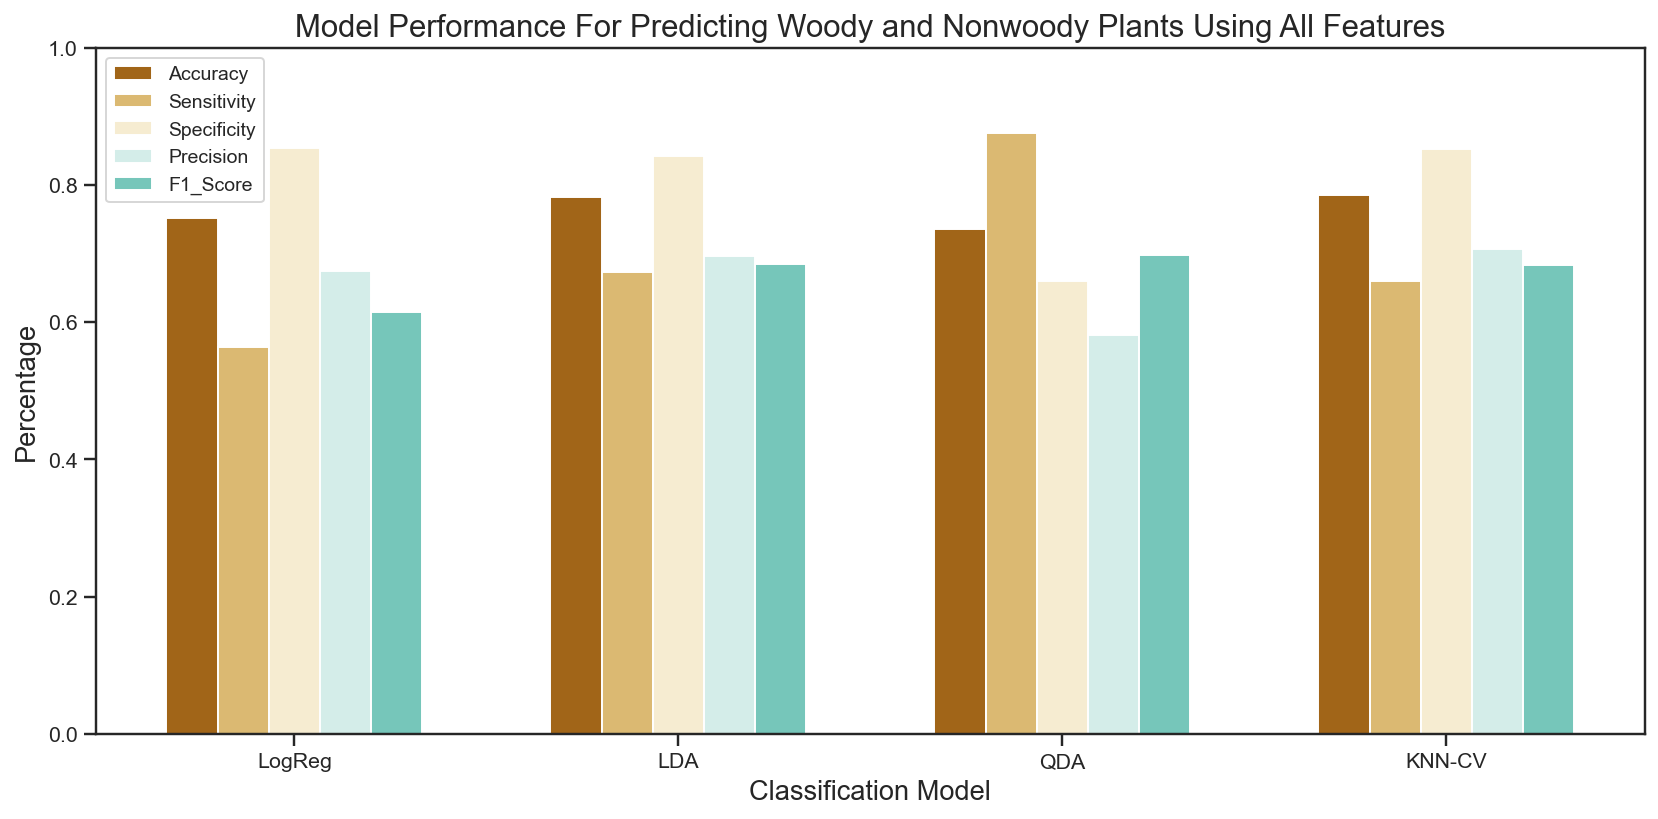

In [40]:
#Bar Graph
models = ['LogReg', 'LDA', 'QDA', 'KNN-CV']
print(models)
accuracies = statallfeatures_dic["Accuracy"]
print("Accuracies" + str(accuracies))
sensitivities = statallfeatures_dic["Sensitivity"]
print("Sen" + str(sensitivities))
specificities = statallfeatures_dic["Specificity"]
print("Spec" + str(specificities))
precisions = statallfeatures_dic["Precision"]
print("P" + str(precisions))
f1_scores = statallfeatures_dic["F1_Score"]
print("F1" + str(f1_scores))

x = 6*np.arange(len(models))
width = 0.8

fig, ax = plt.subplots(figsize=(12, 6))
import seaborn as sns
colors = sns.color_palette("BrBG")

acc = ax.bar(x-width*2, accuracies, width, label='Accuracy', color=colors[0])
sen = ax.bar(x-width, sensitivities, width, label='Sensitivity', color=colors[1])
spe = ax.bar(x,specificities, width, label='Specificity', color=colors[2])
pre = ax.bar(x+width, precisions, width, label='Precision', color=colors[3])
f1 = ax.bar(x+width*2 , f1_scores, width, label='F1_Score', color=colors[4])

ax.set_xlabel('Classification Model', fontsize=14)
ax.set_ylabel('Percentage', fontsize=14)
ax.set_title('Model Performance For Predicting Woody and Nonwoody Plants Using All Features', fontsize=16)
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()
ax.set(ylim=(0.0, 1))


fig.tight_layout()

plt.legend(loc="upper left", prop={'size': 10})
plt.show()

fig.savefig('AllFeaturesPerformance.png')

#Code from https://matplotlib.org/stable/gallery/lines_bars_and_markers/barchart.html#sphx-glr-gallery-lines-bars-and-markers-barchart-py

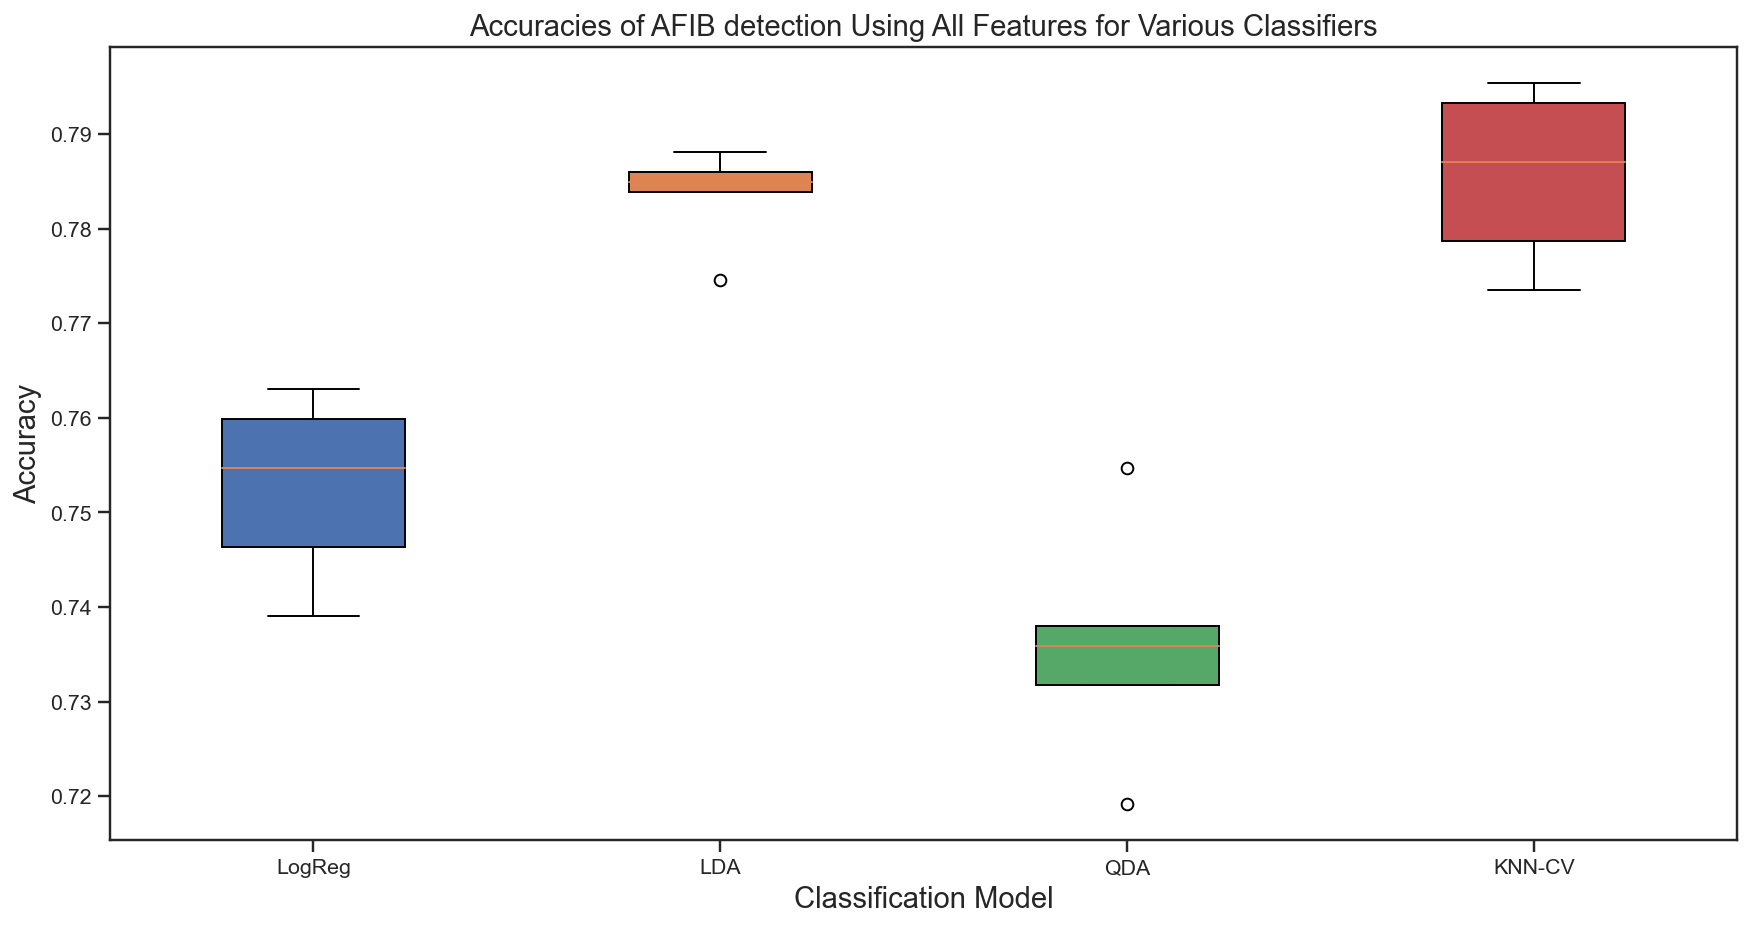

In [41]:
#Box Plot Accuracies

models = ['LogReg', 'LDA', 'QDA', 'KNN-CV']

x = np.arange(len(models))+1

LogRegAcc = indaccs_dic['LogReg']
LDAAcc = indaccs_dic['LDA']
QDAAcc = indaccs_dic['QDA']
KNNAcc = indaccs_dic['KNN']

data = [LogRegAcc, LDAAcc, QDAAcc, KNNAcc]

fig, ax = plt.subplots(figsize = (15,7.5))
bplot = ax.boxplot(data, patch_artist = True)

ax.set_title('Accuracies of AFIB detection Using All Features for Various Classifiers', fontsize=15)
ax.set_xlabel('Classification Model', fontsize=15)
ax.set_ylabel('Accuracy', fontsize=15)
ax.set_xticks(x)
ax.set_xticklabels(models)

import seaborn as sns
#colors = sns.color_palette("colorblind")
colors = sns.color_palette()

for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)
plt.show()

In [42]:
print("Log reg act: " + str(needed))
print("Log reg pred: " + str(tFWC4))
print("QDA act: " + str(needed2))
print("QDA pred: " + str(tFWC2))
print("LDA act: " + str(needed3))
print("LDA pred: " + str(tFWC))
print("KNN act: " + str(needed4))
print("KNN pred: " +str(tFWC3))

Log reg act: 19.396377433556005
Log reg pred: 70.81419624206276
QDA act: 19.396377433556005
QDA pred: 47.26513569927968
LDA act: 19.396377433556005
LDA pred: 66.26304801659231
KNN act: 19.396377433556005
KNN pred: 67.30688935271553


In [43]:
Logerrorrate = abs((needed-tFWC4)/needed) *100
QDAerrorrate = abs((needed-tFWC2)/needed) *100
LDAerrorrate = abs((needed-tFWC)/needed) *100
KNNerrorrate = abs((needed-tFWC3)/needed) *100

print("log ER = " + str(Logerrorrate))
print("QDA ER = " + str(QDAerrorrate))
print("LDA ER = " + str(LDAerrorrate))
print("KNN ER = " + str(KNNerrorrate))

log ER = 265.08980341634935
QDA ER = 143.68022256315933
LDA ER = 241.6258950599523
KNN ER = 247.0075254169558
